# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

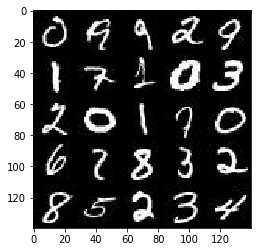

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

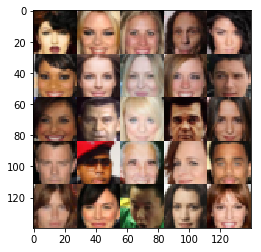

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "input_real")
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), "input_z")
    learning_rate = tf.placeholder(tf.float32, name="lr")
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [95]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    n_units = 4 * 4 * 256
    alpha = 0.2
    stddev = 0.05
    keep_prob = 0.9
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(
            images, 
            64, 
            5, 
            strides=2, 
            padding='same',
            #kernel_initializer=tf.random_normal_initializer(stddev=stddev),
            activation=None
        )
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(
            x1, 
            128, 
            5, 
            strides=2, 
            padding='same',
            #kernel_initializer=tf.random_normal_initializer(stddev=stddev),
            activation=None
        )
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d(
            x2, 
            256, 
            5, 
            strides=2, 
            padding='same',
            #kernel_initializer=tf.random_normal_initializer(stddev=stddev),
            activation=None
        )
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        flat = tf.reshape(x3, (-1, n_units))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [96]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    num_units = 7*7*512
    stddev = 0.05
    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, num_units)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        # shape = 7x7x512
        
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                                       activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        g2 = tf.nn.dropout(g2, keep_prob=keep_prob)
        # shape = 14x14x256
        
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                                       activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)   
        g3 = tf.nn.dropout(g3, keep_prob=keep_prob)
        # shape = 28x28x128
        
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 3, strides=1, padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                                           activation=None)
        # shape = 28x28x5
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [97]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    gen_output = generator(input_z, out_channel_dim)
    disc_output_real, disc_logits_real = discriminator(input_real)
    disc_output_fake, disc_logits_fake = discriminator(gen_output, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_real,
            labels = tf.ones_like(disc_output_real) * (1 - smooth)
        )
    )
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.zeros_like(disc_output_fake)
        )
    )
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.ones_like(disc_output_fake)
        )
    )
    
    disc_loss = disc_loss_real + disc_loss_fake
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [98]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    #gen_ops =  [op for op in update_ops if op.name.startswith('generator')]
    with tf.control_dependencies(update_ops):
        gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)

        return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [99]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [100]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    steps = 0
    total_steps = epoch_count * batch_size
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    disc_opt, 
                    feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate 
                    }
                )
                _ = sess.run(
                    gen_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z, 
                        lr:learning_rate
                    }
                )
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    # show samples
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    

        saver.save(sess, './generator.ckpt')
                
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


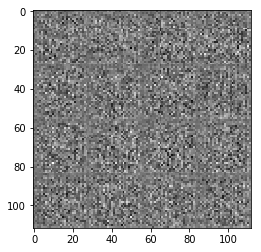

Epoch 1/2... Discriminator Loss: 0.5964... Generator Loss: 1.9817
Epoch 1/2... Discriminator Loss: 0.9385... Generator Loss: 1.7525
Epoch 1/2... Discriminator Loss: 1.2170... Generator Loss: 0.9610
Epoch 1/2... Discriminator Loss: 1.4796... Generator Loss: 0.5618
Epoch 1/2... Discriminator Loss: 1.1692... Generator Loss: 2.9950
Epoch 1/2... Discriminator Loss: 1.1113... Generator Loss: 2.1635
Epoch 1/2... Discriminator Loss: 1.0639... Generator Loss: 1.2884
Epoch 1/2... Discriminator Loss: 1.0623... Generator Loss: 1.3719
Epoch 1/2... Discriminator Loss: 1.4573... Generator Loss: 2.2734
Epoch 1/2... Discriminator Loss: 1.5042... Generator Loss: 2.0991


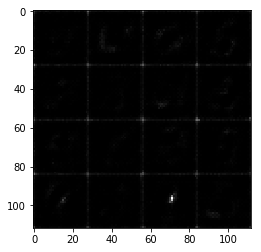

Epoch 1/2... Discriminator Loss: 1.2214... Generator Loss: 0.6469
Epoch 1/2... Discriminator Loss: 1.0706... Generator Loss: 1.6228
Epoch 1/2... Discriminator Loss: 1.3185... Generator Loss: 0.7235
Epoch 1/2... Discriminator Loss: 1.0768... Generator Loss: 1.0438
Epoch 1/2... Discriminator Loss: 0.9533... Generator Loss: 1.2480
Epoch 1/2... Discriminator Loss: 1.0689... Generator Loss: 1.0484
Epoch 1/2... Discriminator Loss: 1.2116... Generator Loss: 0.6116
Epoch 1/2... Discriminator Loss: 0.8698... Generator Loss: 1.8203
Epoch 1/2... Discriminator Loss: 0.9375... Generator Loss: 2.1690
Epoch 1/2... Discriminator Loss: 0.8763... Generator Loss: 1.2417


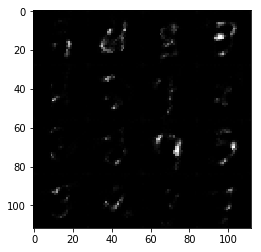

Epoch 1/2... Discriminator Loss: 1.1527... Generator Loss: 2.8998
Epoch 1/2... Discriminator Loss: 0.7589... Generator Loss: 1.6097
Epoch 1/2... Discriminator Loss: 0.8298... Generator Loss: 1.1987
Epoch 1/2... Discriminator Loss: 0.7660... Generator Loss: 1.6614
Epoch 1/2... Discriminator Loss: 0.8424... Generator Loss: 1.3131
Epoch 1/2... Discriminator Loss: 0.8700... Generator Loss: 2.8051
Epoch 1/2... Discriminator Loss: 0.9093... Generator Loss: 3.1891
Epoch 1/2... Discriminator Loss: 0.7200... Generator Loss: 1.8810
Epoch 1/2... Discriminator Loss: 0.7863... Generator Loss: 2.3905
Epoch 1/2... Discriminator Loss: 0.6985... Generator Loss: 2.0386


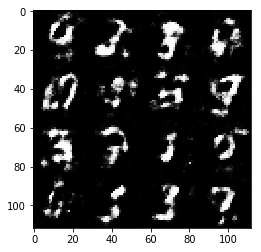

Epoch 1/2... Discriminator Loss: 1.0577... Generator Loss: 3.2359
Epoch 1/2... Discriminator Loss: 0.6439... Generator Loss: 2.0882
Epoch 1/2... Discriminator Loss: 0.6557... Generator Loss: 1.5381
Epoch 1/2... Discriminator Loss: 0.6919... Generator Loss: 1.7674
Epoch 1/2... Discriminator Loss: 0.5950... Generator Loss: 2.9600
Epoch 1/2... Discriminator Loss: 0.6029... Generator Loss: 2.6081
Epoch 1/2... Discriminator Loss: 0.6483... Generator Loss: 2.1070
Epoch 1/2... Discriminator Loss: 1.6942... Generator Loss: 4.7429
Epoch 1/2... Discriminator Loss: 0.6635... Generator Loss: 2.0803
Epoch 1/2... Discriminator Loss: 0.6384... Generator Loss: 2.4985


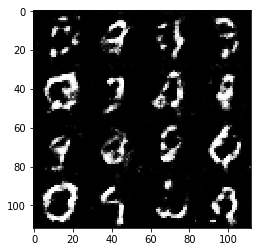

Epoch 1/2... Discriminator Loss: 0.7781... Generator Loss: 1.3858
Epoch 1/2... Discriminator Loss: 0.6503... Generator Loss: 1.5949
Epoch 1/2... Discriminator Loss: 0.7902... Generator Loss: 2.7722
Epoch 1/2... Discriminator Loss: 1.0403... Generator Loss: 0.9327
Epoch 1/2... Discriminator Loss: 0.8153... Generator Loss: 1.8594
Epoch 1/2... Discriminator Loss: 0.7704... Generator Loss: 2.2486
Epoch 1/2... Discriminator Loss: 0.7916... Generator Loss: 2.8554
Epoch 1/2... Discriminator Loss: 0.7562... Generator Loss: 1.5909
Epoch 1/2... Discriminator Loss: 1.2819... Generator Loss: 0.7042
Epoch 1/2... Discriminator Loss: 1.2666... Generator Loss: 0.6798


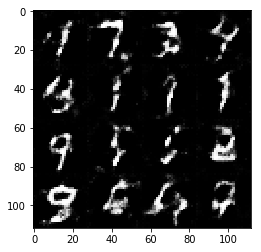

Epoch 1/2... Discriminator Loss: 0.8286... Generator Loss: 1.2981
Epoch 1/2... Discriminator Loss: 1.1562... Generator Loss: 3.6552
Epoch 1/2... Discriminator Loss: 0.9819... Generator Loss: 1.1207
Epoch 1/2... Discriminator Loss: 0.7897... Generator Loss: 1.8016
Epoch 1/2... Discriminator Loss: 0.9621... Generator Loss: 1.2141
Epoch 1/2... Discriminator Loss: 1.2149... Generator Loss: 2.5236
Epoch 1/2... Discriminator Loss: 1.0077... Generator Loss: 2.2368
Epoch 1/2... Discriminator Loss: 1.1048... Generator Loss: 0.8375
Epoch 1/2... Discriminator Loss: 0.8853... Generator Loss: 1.2844
Epoch 1/2... Discriminator Loss: 1.1559... Generator Loss: 2.9633


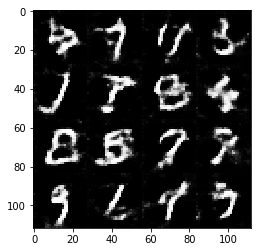

Epoch 1/2... Discriminator Loss: 1.0238... Generator Loss: 1.0206
Epoch 1/2... Discriminator Loss: 0.8840... Generator Loss: 1.8551
Epoch 1/2... Discriminator Loss: 0.8224... Generator Loss: 2.6310
Epoch 1/2... Discriminator Loss: 0.8222... Generator Loss: 1.4799
Epoch 1/2... Discriminator Loss: 0.8752... Generator Loss: 1.5179
Epoch 1/2... Discriminator Loss: 0.9501... Generator Loss: 1.6691
Epoch 1/2... Discriminator Loss: 1.0590... Generator Loss: 1.9387
Epoch 1/2... Discriminator Loss: 1.0119... Generator Loss: 0.9564
Epoch 1/2... Discriminator Loss: 0.9800... Generator Loss: 1.0775
Epoch 1/2... Discriminator Loss: 0.8030... Generator Loss: 1.4628


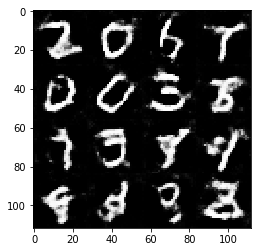

Epoch 1/2... Discriminator Loss: 0.7928... Generator Loss: 1.7252
Epoch 1/2... Discriminator Loss: 0.8668... Generator Loss: 1.4519
Epoch 1/2... Discriminator Loss: 0.9347... Generator Loss: 1.1688
Epoch 1/2... Discriminator Loss: 0.9993... Generator Loss: 1.0129
Epoch 1/2... Discriminator Loss: 0.8703... Generator Loss: 1.2634
Epoch 1/2... Discriminator Loss: 0.9420... Generator Loss: 1.0823
Epoch 1/2... Discriminator Loss: 0.8468... Generator Loss: 1.4526
Epoch 1/2... Discriminator Loss: 0.9399... Generator Loss: 2.1434
Epoch 1/2... Discriminator Loss: 0.9277... Generator Loss: 1.4111
Epoch 1/2... Discriminator Loss: 1.1000... Generator Loss: 0.7108


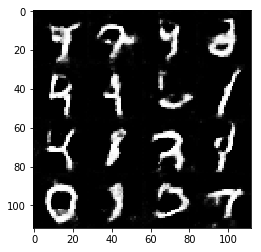

Epoch 1/2... Discriminator Loss: 0.8086... Generator Loss: 1.9653
Epoch 1/2... Discriminator Loss: 0.7795... Generator Loss: 1.6339
Epoch 1/2... Discriminator Loss: 0.7911... Generator Loss: 1.2709
Epoch 1/2... Discriminator Loss: 1.0171... Generator Loss: 1.0263
Epoch 1/2... Discriminator Loss: 1.1113... Generator Loss: 0.7500
Epoch 1/2... Discriminator Loss: 0.9913... Generator Loss: 0.9329
Epoch 1/2... Discriminator Loss: 1.3470... Generator Loss: 2.9149
Epoch 1/2... Discriminator Loss: 0.8435... Generator Loss: 1.3735
Epoch 1/2... Discriminator Loss: 0.8335... Generator Loss: 1.4981
Epoch 1/2... Discriminator Loss: 0.8527... Generator Loss: 1.6562


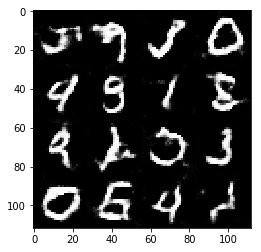

Epoch 1/2... Discriminator Loss: 1.0541... Generator Loss: 0.9126
Epoch 1/2... Discriminator Loss: 0.7316... Generator Loss: 1.6397
Epoch 1/2... Discriminator Loss: 0.9190... Generator Loss: 1.8068
Epoch 2/2... Discriminator Loss: 1.0190... Generator Loss: 0.8948
Epoch 2/2... Discriminator Loss: 0.9225... Generator Loss: 1.4878
Epoch 2/2... Discriminator Loss: 1.0456... Generator Loss: 0.8990
Epoch 2/2... Discriminator Loss: 0.7878... Generator Loss: 1.4035
Epoch 2/2... Discriminator Loss: 0.9703... Generator Loss: 1.9174
Epoch 2/2... Discriminator Loss: 0.8497... Generator Loss: 1.3018
Epoch 2/2... Discriminator Loss: 0.8551... Generator Loss: 1.2273


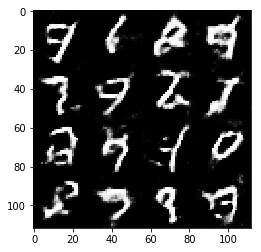

Epoch 2/2... Discriminator Loss: 0.8843... Generator Loss: 1.0623
Epoch 2/2... Discriminator Loss: 0.8934... Generator Loss: 1.7552
Epoch 2/2... Discriminator Loss: 0.8356... Generator Loss: 1.3289
Epoch 2/2... Discriminator Loss: 0.8863... Generator Loss: 1.6823
Epoch 2/2... Discriminator Loss: 0.8554... Generator Loss: 1.3589
Epoch 2/2... Discriminator Loss: 0.8582... Generator Loss: 1.9907
Epoch 2/2... Discriminator Loss: 1.1241... Generator Loss: 0.8049
Epoch 2/2... Discriminator Loss: 0.8374... Generator Loss: 1.2577
Epoch 2/2... Discriminator Loss: 0.7097... Generator Loss: 1.6188
Epoch 2/2... Discriminator Loss: 0.8720... Generator Loss: 1.2678


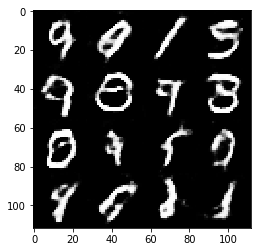

Epoch 2/2... Discriminator Loss: 1.0134... Generator Loss: 1.0556
Epoch 2/2... Discriminator Loss: 1.3056... Generator Loss: 2.9407
Epoch 2/2... Discriminator Loss: 0.7990... Generator Loss: 1.3398
Epoch 2/2... Discriminator Loss: 0.8919... Generator Loss: 0.9963
Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 0.9207
Epoch 2/2... Discriminator Loss: 0.9453... Generator Loss: 0.9617
Epoch 2/2... Discriminator Loss: 1.5006... Generator Loss: 3.3422
Epoch 2/2... Discriminator Loss: 0.8157... Generator Loss: 1.4919
Epoch 2/2... Discriminator Loss: 0.9223... Generator Loss: 0.9778
Epoch 2/2... Discriminator Loss: 0.7448... Generator Loss: 1.3934


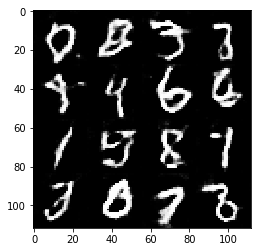

Epoch 2/2... Discriminator Loss: 0.7153... Generator Loss: 1.7209
Epoch 2/2... Discriminator Loss: 0.8843... Generator Loss: 1.7898
Epoch 2/2... Discriminator Loss: 0.9217... Generator Loss: 1.1301
Epoch 2/2... Discriminator Loss: 0.8023... Generator Loss: 1.4793
Epoch 2/2... Discriminator Loss: 0.8791... Generator Loss: 1.0257
Epoch 2/2... Discriminator Loss: 0.7414... Generator Loss: 1.5185
Epoch 2/2... Discriminator Loss: 0.6863... Generator Loss: 2.2210
Epoch 2/2... Discriminator Loss: 0.6919... Generator Loss: 1.8779
Epoch 2/2... Discriminator Loss: 1.0037... Generator Loss: 3.1802
Epoch 2/2... Discriminator Loss: 0.7598... Generator Loss: 2.2620


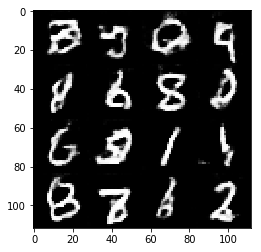

Epoch 2/2... Discriminator Loss: 0.7264... Generator Loss: 2.0642
Epoch 2/2... Discriminator Loss: 0.9983... Generator Loss: 2.0642
Epoch 2/2... Discriminator Loss: 0.8335... Generator Loss: 1.3591
Epoch 2/2... Discriminator Loss: 0.9396... Generator Loss: 0.9941
Epoch 2/2... Discriminator Loss: 0.8262... Generator Loss: 1.7621
Epoch 2/2... Discriminator Loss: 0.7508... Generator Loss: 1.9392
Epoch 2/2... Discriminator Loss: 0.7757... Generator Loss: 1.7621
Epoch 2/2... Discriminator Loss: 0.7557... Generator Loss: 1.1660
Epoch 2/2... Discriminator Loss: 0.8530... Generator Loss: 1.1316
Epoch 2/2... Discriminator Loss: 1.0027... Generator Loss: 2.4271


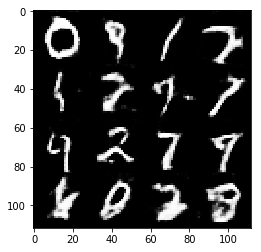

Epoch 2/2... Discriminator Loss: 0.8104... Generator Loss: 1.5145
Epoch 2/2... Discriminator Loss: 0.7722... Generator Loss: 1.3522
Epoch 2/2... Discriminator Loss: 0.8980... Generator Loss: 1.1044
Epoch 2/2... Discriminator Loss: 0.8057... Generator Loss: 1.3302
Epoch 2/2... Discriminator Loss: 0.8404... Generator Loss: 1.5944
Epoch 2/2... Discriminator Loss: 0.7301... Generator Loss: 1.8402
Epoch 2/2... Discriminator Loss: 0.6879... Generator Loss: 1.6052
Epoch 2/2... Discriminator Loss: 0.7146... Generator Loss: 1.4671
Epoch 2/2... Discriminator Loss: 0.8049... Generator Loss: 2.0356
Epoch 2/2... Discriminator Loss: 0.8253... Generator Loss: 1.1144


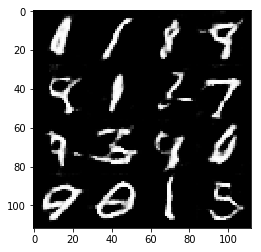

Epoch 2/2... Discriminator Loss: 1.0421... Generator Loss: 0.9626
Epoch 2/2... Discriminator Loss: 1.1269... Generator Loss: 0.8584
Epoch 2/2... Discriminator Loss: 0.8223... Generator Loss: 1.3539
Epoch 2/2... Discriminator Loss: 0.9547... Generator Loss: 0.9683
Epoch 2/2... Discriminator Loss: 0.6303... Generator Loss: 2.0582
Epoch 2/2... Discriminator Loss: 2.1905... Generator Loss: 0.2635
Epoch 2/2... Discriminator Loss: 1.0096... Generator Loss: 1.6236
Epoch 2/2... Discriminator Loss: 0.8079... Generator Loss: 1.7931
Epoch 2/2... Discriminator Loss: 0.9798... Generator Loss: 1.1835
Epoch 2/2... Discriminator Loss: 0.7769... Generator Loss: 1.5157


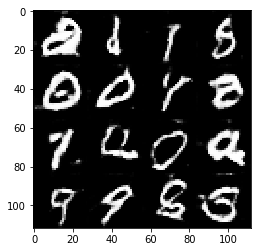

Epoch 2/2... Discriminator Loss: 0.7639... Generator Loss: 1.6162
Epoch 2/2... Discriminator Loss: 0.7522... Generator Loss: 1.8715
Epoch 2/2... Discriminator Loss: 0.7627... Generator Loss: 1.5273
Epoch 2/2... Discriminator Loss: 0.7377... Generator Loss: 1.7687
Epoch 2/2... Discriminator Loss: 0.7086... Generator Loss: 1.5864
Epoch 2/2... Discriminator Loss: 0.7542... Generator Loss: 1.4225
Epoch 2/2... Discriminator Loss: 0.6939... Generator Loss: 1.5794
Epoch 2/2... Discriminator Loss: 1.1122... Generator Loss: 2.9201
Epoch 2/2... Discriminator Loss: 0.8108... Generator Loss: 2.0491
Epoch 2/2... Discriminator Loss: 0.7836... Generator Loss: 1.4026


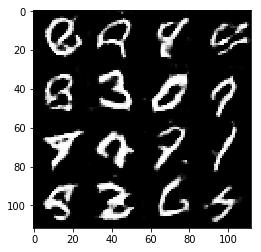

Epoch 2/2... Discriminator Loss: 0.6841... Generator Loss: 1.5590
Epoch 2/2... Discriminator Loss: 0.7278... Generator Loss: 1.6329
Epoch 2/2... Discriminator Loss: 0.7253... Generator Loss: 1.5860
Epoch 2/2... Discriminator Loss: 0.8264... Generator Loss: 1.7490
Epoch 2/2... Discriminator Loss: 0.8030... Generator Loss: 1.7892
Epoch 2/2... Discriminator Loss: 0.6830... Generator Loss: 1.6221
Epoch 2/2... Discriminator Loss: 1.1509... Generator Loss: 2.6180
Epoch 2/2... Discriminator Loss: 0.8986... Generator Loss: 0.9334
Epoch 2/2... Discriminator Loss: 0.8931... Generator Loss: 1.1340
Epoch 2/2... Discriminator Loss: 0.8990... Generator Loss: 1.1921


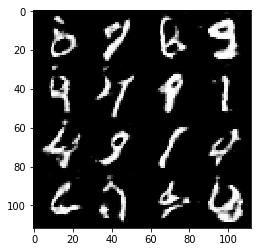

Epoch 2/2... Discriminator Loss: 0.8884... Generator Loss: 1.0794
Epoch 2/2... Discriminator Loss: 1.5193... Generator Loss: 0.6530
Epoch 2/2... Discriminator Loss: 0.8752... Generator Loss: 1.0497
Epoch 2/2... Discriminator Loss: 0.8296... Generator Loss: 1.2056
Epoch 2/2... Discriminator Loss: 0.8306... Generator Loss: 1.5815
Epoch 2/2... Discriminator Loss: 0.6916... Generator Loss: 1.6633
Epoch 2/2... Discriminator Loss: 0.6573... Generator Loss: 1.9516


In [101]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(
        epochs, 
        batch_size, 
        z_dim, 
        learning_rate, 
        beta1, 
        mnist_dataset.get_batches,
        mnist_dataset.shape, 
        mnist_dataset.image_mode
    )
    #plt.plot(losses)
    #plt.show()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


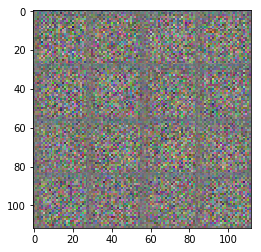

Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 1.1361
Epoch 1/1... Discriminator Loss: 0.7306... Generator Loss: 1.8187
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 6.5179
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 4.5505
Epoch 1/1... Discriminator Loss: 0.4812... Generator Loss: 3.2721
Epoch 1/1... Discriminator Loss: 0.4865... Generator Loss: 2.7042
Epoch 1/1... Discriminator Loss: 0.4058... Generator Loss: 3.8296
Epoch 1/1... Discriminator Loss: 0.4270... Generator Loss: 3.3570
Epoch 1/1... Discriminator Loss: 0.4868... Generator Loss: 2.4427
Epoch 1/1... Discriminator Loss: 0.4709... Generator Loss: 4.3206


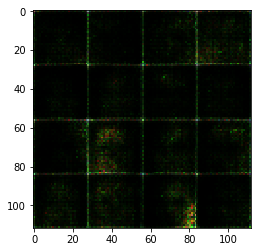

Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 3.3761
Epoch 1/1... Discriminator Loss: 0.4037... Generator Loss: 3.8121
Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 4.1398
Epoch 1/1... Discriminator Loss: 0.3843... Generator Loss: 3.9220
Epoch 1/1... Discriminator Loss: 0.4554... Generator Loss: 6.1826
Epoch 1/1... Discriminator Loss: 0.5621... Generator Loss: 2.0879
Epoch 1/1... Discriminator Loss: 1.7472... Generator Loss: 0.4200
Epoch 1/1... Discriminator Loss: 0.6345... Generator Loss: 2.7111
Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 3.0717
Epoch 1/1... Discriminator Loss: 0.4590... Generator Loss: 3.1413


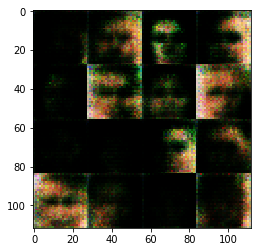

Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 0.6418... Generator Loss: 1.7448
Epoch 1/1... Discriminator Loss: 0.5315... Generator Loss: 3.3180
Epoch 1/1... Discriminator Loss: 0.6756... Generator Loss: 1.6767
Epoch 1/1... Discriminator Loss: 0.5811... Generator Loss: 2.9768
Epoch 1/1... Discriminator Loss: 0.5680... Generator Loss: 2.0092
Epoch 1/1... Discriminator Loss: 0.6412... Generator Loss: 1.6258
Epoch 1/1... Discriminator Loss: 0.7247... Generator Loss: 2.1744
Epoch 1/1... Discriminator Loss: 2.0582... Generator Loss: 0.2966
Epoch 1/1... Discriminator Loss: 0.6039... Generator Loss: 2.0028


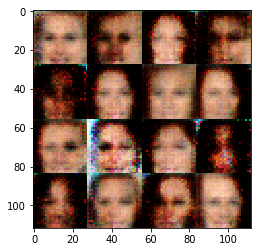

Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 1.3341
Epoch 1/1... Discriminator Loss: 1.5960... Generator Loss: 0.4732
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 3.0332
Epoch 1/1... Discriminator Loss: 0.5776... Generator Loss: 2.7143
Epoch 1/1... Discriminator Loss: 0.9059... Generator Loss: 3.1171
Epoch 1/1... Discriminator Loss: 0.6348... Generator Loss: 1.6938
Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 1.2783
Epoch 1/1... Discriminator Loss: 0.6826... Generator Loss: 1.4981


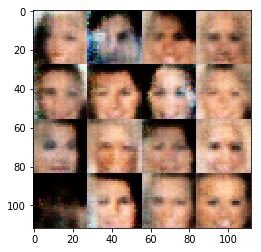

Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 0.6531... Generator Loss: 2.3000
Epoch 1/1... Discriminator Loss: 0.7449... Generator Loss: 1.9971
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 1.3620
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.1847
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 2.0695
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 2.2094
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.8149
Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 1.3841


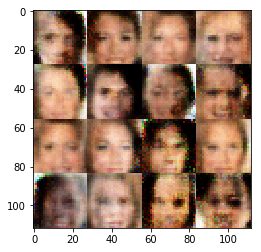

Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 1.2433
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 1.4442
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.4977
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 2.4664
Epoch 1/1... Discriminator Loss: 0.8803... Generator Loss: 1.1613
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 1.1217
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 1.3839


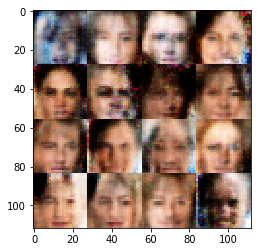

Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 2.8846
Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 1.8606
Epoch 1/1... Discriminator Loss: 3.0062... Generator Loss: 4.1475
Epoch 1/1... Discriminator Loss: 1.5759... Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 1.9812
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 1.9779
Epoch 1/1... Discriminator Loss: 0.7844... Generator Loss: 1.3785
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 1.3043
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 1.4299


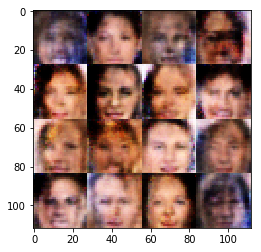

Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 1.0571
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 2.1510
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 1.8031
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 1.9852
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 1.0172


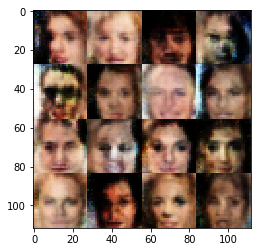

Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 1.4659
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 1.0681
Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 1.4570
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 1.0734
Epoch 1/1... Discriminator Loss: 1.9981... Generator Loss: 2.9988
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 1.2832
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.6453


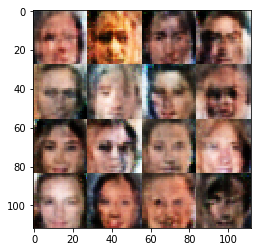

Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 1.1780
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 1.5693
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 2.0619
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 1.5952... Generator Loss: 2.0549
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 1.2068
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 1.2041
Epoch 1/1... Discriminator Loss: 1.9998... Generator Loss: 2.8381
Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 1.2641


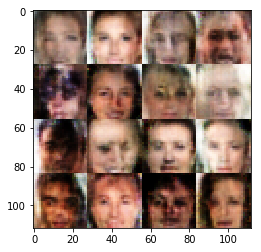

Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 1.6589
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.9672... Generator Loss: 0.2583
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.8694


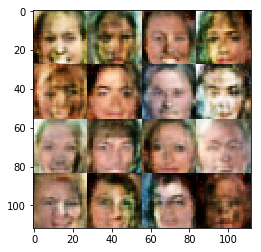

Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.7612... Generator Loss: 0.3423
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 1.1263
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 1.0843


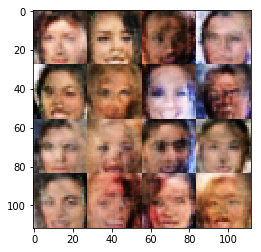

Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.1352
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 1.1395
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 1.4737
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 1.6462
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.8715


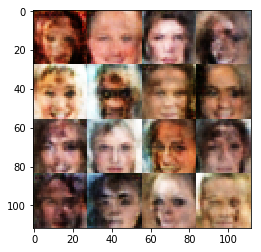

Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 1.2229
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 1.3685
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 1.0467


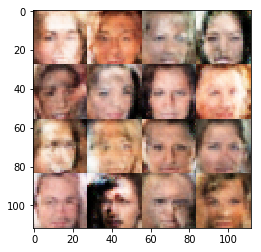

Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 1.1624
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 1.0940
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 1.6811
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 1.1257


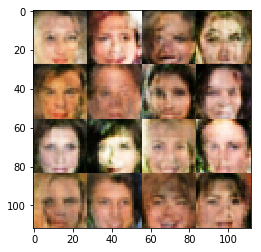

Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 2.0320
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 1.2883
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 1.3825
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 1.4563
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 1.4199


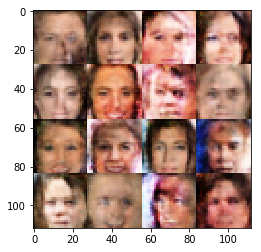

Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 1.1107
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 2.0120
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 1.6738
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 1.3437
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.0896
Epoch 1/1... Discriminator Loss: 1.6373... Generator Loss: 0.4586
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 1.1028


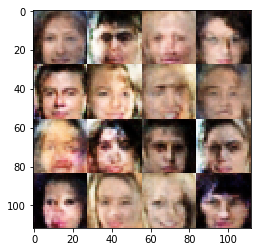

Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 1.1246
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 2.2160
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.6724... Generator Loss: 0.4087
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.7144


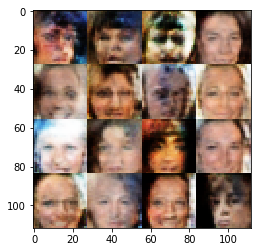

Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 1.4343
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 1.7866
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 1.6094
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 1.4271
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 1.1312
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 1.1235


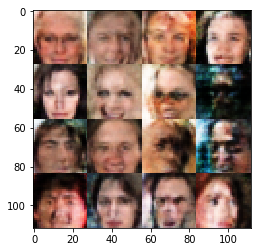

Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 1.1990
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 0.9102
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 1.6410
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 1.3558
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.8341


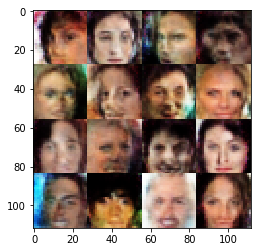

Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 1.7698
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.9873
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 1.3177
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 1.2550
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 1.1170
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.3786
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.8566


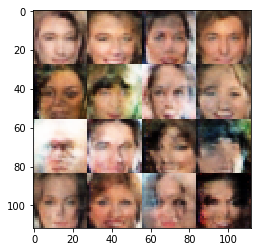

Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.5286
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 1.2724
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 1.6074


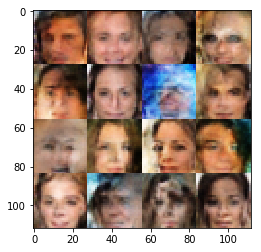

Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 1.1418
Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 1.0426
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 1.3389
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 1.3129
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.9932


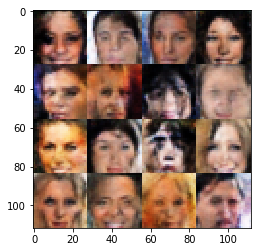

Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 1.3260
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 1.1900
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.8074... Generator Loss: 0.3346
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 1.1698
Epoch 1/1... Discriminator Loss: 1.1398... Generator Loss: 0.7907


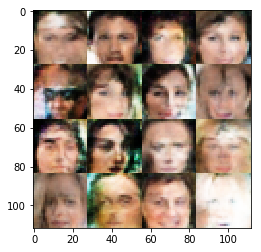

Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 1.3182
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 1.3331
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 1.1384


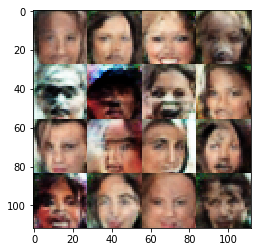

Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 1.1223
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 1.5083
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 1.3634
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 1.3959
Epoch 1/1... Discriminator Loss: 1.7608... Generator Loss: 0.3583
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 1.1321


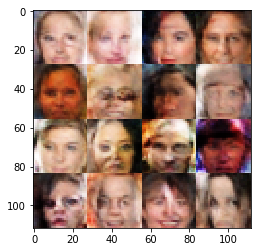

Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 1.3650
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.6812


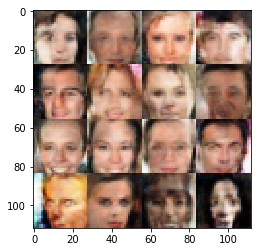

Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 1.2655
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.4533
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.1319
Epoch 1/1... Discriminator Loss: 0.9580... Generator Loss: 1.4960
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 1.1816
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.5429


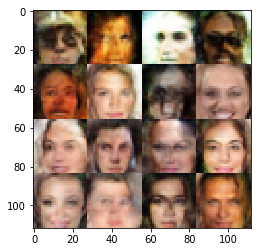

Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 1.1709
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 1.4167
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 1.7366
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 1.3058
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.7736


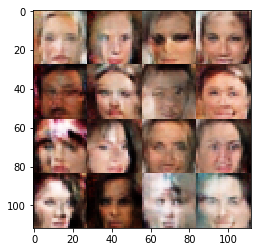

Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 1.0464
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 1.4129
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 1.1598


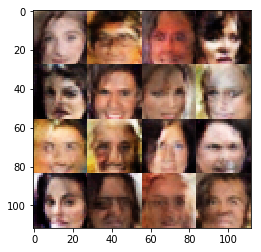

Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 1.7107
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.9902
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.9495
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 1.0403
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 1.0532


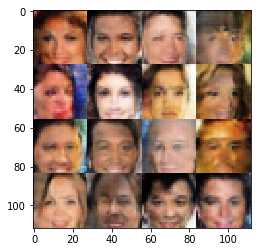

Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 1.0790
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 1.1432
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 1.8048
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 1.0736
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 1.2813


In [102]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.